This tutorial can be downloaded [link](http://greatfire.uchicago.edu/west-public/West/raw/master/doc/tutorials/west_100.ipynb).

# 1.0 Getting Started: GW calculation

In order to compute the GW electronic structure of the silane molecule you need to run `pw.x`, `wstat.x` and `wfreq.x` in sequence. Documentation for building and installing WEST is available at this [link](http://www.west-code.org/doc/West/latest/installation.html).

The GW workflow involves three sequental steps: 
- Step 1: Ground State
- Step 2: Screening
- Step 3: Quasiparticle corrections

Each step is explained below. At the end of step 3 you will be able to obtain the electronic structure of the silane molecule at the $G_0W_0 @ PBE$ level of theory, where the GW is computed without empty states and with full frequency integration using the countour deformation technique. For more information about the implementation, we refer to [Govoni et al., J. Chem. Theory Comput. 11, 2680 (2015)](https://doi.org/10.1021/ct500958p).

## Step 1: Ground State 

The ground state electronic structure of silane molecule with [QuantumEspresso](https://www.quantum-espresso.org/) is obtained by running `pw.x`. Currently, WEST supports the version 6.1.0 of Quantum Espresso. The pseudopotential files for **Si** and **H** in UPF format can be downloaded from: [QE-PP](https://www.quantum-espresso.org/pseudopotentials) database, or from [SG15](http://www.quantum-simulation.org/potentials/sg15_oncv/upf/) database. Check out the `pw.x` [input description](https://www.quantum-espresso.org/Doc/INPUT_PW.html) in order to generate an input file for QuantumEspresso called `pw.in`. 

Download these files in your current working directory:

In [1]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/pw.in
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/H_ONCV_PBE-1.2.upf
wget -N -q http://www.quantum-simulation.org/potentials/sg15_oncv/upf/Si_ONCV_PBE-1.2.upf

Let's inspect the ``pw.in`` file, input for ``pw.x``.

In [2]:
%%bash
cat pw.in

&control
calculation  = 'scf'
restart_mode = 'from_scratch'
pseudo_dir   = './'
outdir       = './'
prefix       = 'silane'
wf_collect   = .TRUE.
/
&system
ibrav           = 1
celldm(1)       = 20
nat             = 5
ntyp            = 2
ecutwfc         = 25.0
nbnd            = 10
assume_isolated ='mp'
/
&electrons
diago_full_acc = .TRUE.
/
ATOMIC_SPECIES
Si 28.0855  Si_ONCV_PBE-1.2.upf
H  1.00794   H_ONCV_PBE-1.2.upf
ATOMIC_POSITIONS bohr
Si      10.000000   10.000000  10.000000
H       11.614581   11.614581  11.614581
H        8.385418    8.385418  11.614581
H        8.385418   11.614581   8.385418
H       11.614581    8.385418   8.385418
K_POINTS {gamma}


Run ``pw.in`` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 pw.x < pw.in > pw.out

The output file ``pw.out`` contains information about the ground state calculation.

## Step 2: Screening

The static dielectric screening is computed using the projective dielectric eigendecomposition (PDEP) technique. Check out the ``wstat.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wstat.in``.

Download this file in your current working directory:

In [3]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wstat.in

Let's inspect the ``wstat.in`` file, input for ``wstat.x``.

In [4]:
%%bash
cat wstat.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

Run ``wstat.in`` on 2 cores.

In [ ]:
%%bash
mpirun -n 2 wstat.x -i wstat.in > wstat.out

The output file ``wstat.out`` contains information about the PDEP iterations, and the dielectric eigenvalues can be found in the file ``<west_prefix>.wstat.save/wstat.json``. 

Below we show how to load, print, and plot the PDEP eigenvalues.

In [5]:
import json
import numpy as np

# Load the output data
with open('silane.wstat.save/wstat.json') as json_file:
    data = json.load(json_file)
    
# Extract converged PDEP eigenvalues
ev = np.array(data["exec"]["davitr"][-1]["ev"],dtype="f8")

In [6]:
# Print
print(ev)

[-1.27478021 -1.19127122 -1.19120182 -1.19117265 -0.82405876 -0.82403634
 -0.8239814  -0.63586048 -0.62939276 -0.62938952 -0.5005205  -0.50049623
 -0.50047244 -0.42993907 -0.42992203 -0.42991856 -0.23238121 -0.23237804
 -0.23237301 -0.18322991 -0.18321449 -0.18320583 -0.1783964  -0.17750084
 -0.17749955 -0.1459245  -0.14591779 -0.1459143  -0.12258015 -0.12012226
 -0.12011826 -0.12011616 -0.11634693 -0.11634526 -0.11528926 -0.11528499
 -0.11528457 -0.09408215 -0.09408058 -0.09408013 -0.07995372 -0.07995119
 -0.07995041 -0.07477358 -0.07310084 -0.07309955 -0.0657784  -0.06577326
 -0.06576894 -0.06313431]


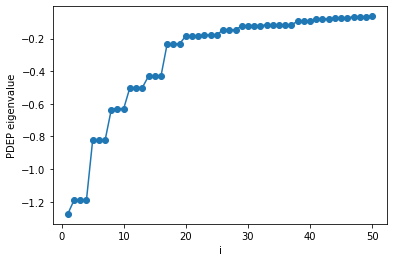

In [7]:
import matplotlib.pyplot as plt

# Create x-axis
iv = np.linspace(1,ev.size,ev.size,endpoint=True)

# Plot 
plt.plot(iv,ev,'o-',label="XXX")
plt.xlabel("i")
plt.ylabel("PDEP eigenvalue")

plt.show()

## Step 3: Quasiparticle corrections

The GW electronic structure is computed treating the frequency integration of the correlation part of the self energy with the Contour Deformation techinique and by computing the dielectric screening at multipole frequencies with Lanczos iterations. Check out the ``wfreq.x`` [input description](http://www.west-code.org/doc/West/latest/) and generate an input file for WEST called ``wfreq.in``.

Download this file in your current working directory:

In [8]:
%%bash
wget -N -q http://www.west-code.org/doc/training/silane/wfreq.in

Let's inspect the ``wfreq.in`` file, input for ``wfreq.x``.

In [9]:
%%bash
cat wfreq.in

input_west:
    qe_prefix: silane
    west_prefix: silane
    outdir: ./

wstat_control:
    wstat_calculation: S
    n_pdep_eigen: 50

wfreq_control:
    wfreq_calculation: XWGQ
    n_pdep_eigen_to_use: 50
    qp_bandrange: [1,5]
    n_refreq: 300
    ecut_refreq: 2.0

Run ``wfreq.in`` on 2 cores.

In [ ]:
%%bash 
mpirun -n 2 wfreq.x -i wfreq.in > wfreq.out 

The output file ``wfreq.out`` contains information about the calculation of the GW self-energy, and the corrected electronic structure can be found in the file ``<west_prefix>.wfreq.save/wfreq.json``.

Below we show how to load, print, and plot the quasiparticle corrections. 

In [10]:
import json
import numpy as np

# Load the output data
with open('silane.wfreq.save/wfreq.json') as json_file:
    data = json.load(json_file)

# Extract converged quasiparticle (QP) corrections
k=1 
kindex = f"K{k:06d}"
    
bandmap = data["output"]["Q"]["bandmap"]
eqp = data["output"]["Q"][kindex]

In [11]:
# Print QP corrections
print (f"{'k':^10} | {'band':^10} | {'eks [eV]':^15} | {'eqpLin [eV]':^15} | {'eqpSec [eV]':^15}")
print(77*"-")
for i, b in enumerate(bandmap) : 
    print(f"{k:^10} | {b:^10} | {eqp['eks'][i]:^15.3f} | {eqp['eqpLin'][i]:^15.3f} | {eqp['eqpSec'][i]:^15.3f}")

    k      |    band    |    eks [eV]     |   eqpLin [eV]   |   eqpSec [eV]  
-----------------------------------------------------------------------------
    1      |     4      |     -8.230      |     -12.150     |     -12.044    
    1      |     5      |     -0.466      |      0.666      |      0.665     


Explanation of keys:

- `eks` : Kohn-Sham energy (obtained in Step 1)
- `eqpLin` : Quasiparticle energy ($G_0W_0 @ PBE$), obtained by approximating the self-energy to first order in the frequency
- `eqpSec` : Quasiparticle energy ($G_0W_0 @ PBE$)